# Initialization

In [2]:
# Import the class to read the file galaxies.hdf5
from GalformRun_basic import * 
import pandas as pd

%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})

import time
import eagleSqlTools as egl
con = egl.connect(user="giorgio",password='BN401kmd') 

In [3]:
# Create an instance of the class GalformRun 
# in order to use functins like .get() and .magnitude()
g = GalformRun('/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/')

In [4]:
# example of how to get the rest-frame V magnitude 
g.magnitude("V_r",1.1734,extinction=True)

array([-16.33772 , -18.87405 , -14.796329, ..., -11.372037, -12.46811 ,
       -13.917074], dtype=float32)

# VIOLETTA ALL GALAXIES

# Download from VIRGO snaps 37 and 47 and save into txt files in COSMA

## Snapshot = 37

In [30]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=37'

t1 = time.time()
ALL_GALAXIES_37 = egl.execute_query(con,Q)
t2 = time.time()

In [48]:
print(t2-t1," seconds")

301.9414653778076  seconds


In [45]:
ALL37 = pd.DataFrame(ALL_GALAXIES_37)

In [46]:
ALL37.to_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ')

## Snapshot = 47

In [49]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=47'

t1 = time.time()
ALL_GALAXIES_47 = egl.execute_query(con,Q)
t2 = time.time()
print(t2-t1," seconds")

317.3331735134125  seconds


In [50]:
ALL47 = pd.DataFrame(ALL_GALAXIES_47)

In [51]:
t1 = time.time()
ALL47.to_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ')
t2 = time.time()
print(t2-t1," seconds")

173.4451880455017  seconds


# Read from txt file 

In [5]:
ALL37 = pd.read_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
ALL47 = pd.read_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Check Plot: Luminosity function Violetta

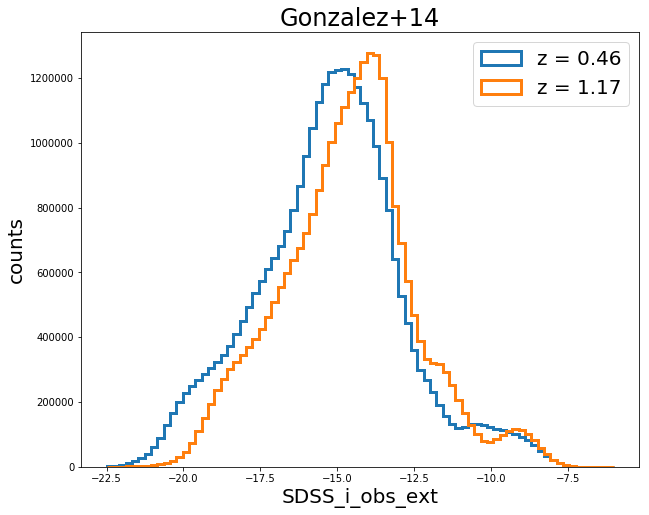

In [7]:
plt.figure(figsize=(10,8))
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Gonzalez+14')
plt.legend()
#plt.savefig('./plots/Violetta_luminosity_function.png')
plt.show()

# COSMOLOGY

In [8]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [9]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# alternative to keep fix the number of points

In [53]:
def EDGE_fixed_Npoints(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_Nbins=15,y_points_per_bin=4000,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    print('Computing...')
    #y_Nbins = int((y_max - y_min) / y_bin_size)
    
    y_bin_step = float((y_max - y_min) / y_Nbins)
    
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    
    #loop on y bins
    for i in range(y_Nbins):
        y_center  = y_min + y_bin_step * i
        # define the y bin which contains at least y_points_per bin
        
        select_y_in_ybin = [[]]
        y_epsilon= 0.
        while (len(select_y_in_ybin[0])<y_points_per_bin): 
            y_epsilon = y_epsilon + 0.005
            y_low = y_center-y_epsilon
            y_high = y_center+y_epsilon
        
            select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        print(y_epsilon*2)      
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    print('...done.')
    return np.array(x_edge), np.array(y_edge)

# Galform Run (Giorgio)

# Write Galform output in txt files (you don't want to do it again)

In [32]:
def Create_data(volume=0,snap=37,zsnap=1.1734,feedback=True):
    '''Function to read the output of Galform and write it in a txt file in the folder ./txt_data'''
    #create right path
    if feedback: 
        fb = 'gp14'
        fb_save = 'feedback'
    else: 
        fb = 'gp14.nofeedback'
        fb_save= 'nofeedback'
        
    path = '/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/'+fb+'/iz'+str(snap)+'/ivol'+str(volume)+'/'
    #path= '../data/uvi'+str(snap)+'_'+fb+'_vol'+str(volume)+'.txt'
    print(path)
    #read data from galaxies.hdf5 using the class GalformRun
    G = GalformRun(path)
    #u = np.array(G.get("mag_SDSS-u_r_tot_ext",1.1734))
    u = np.array(G.magnitude("SDSS-u_r",zsnap,extinction=True))
    #v = np.array(G.get("mag_V_r_tot_ext",zsnap))
    v = np.array(G.magnitude("V_r",zsnap,extinction=True))
    #i = np.array(G.get("mag_SDSS-i_o_tot_ext",zsnap))
    i = np.array(G.magnitude("SDSS-i_o",zsnap,extinction=True))
    #crete pandas dataframe with data
    df = pd.DataFrame(data={'u':u , 'v':v , 'i':i})
    #save dataframe in a txt file
    df.to_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(volume)+'.txt',index=None,sep=' ')
    return u,v,i

In [33]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol9/


In [34]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol9/


In [35]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol9/


In [36]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol9/


# Read from txt and add subvolumes

In [10]:
def Add_subvolumes(snap=47,feedback=False):
    '''Read all the subvolumes (0 to 9) for the specified snapshot and for the specified AGN feedback scenario'''
    u_tot = []
    v_tot = []
    i_tot = []
    for i_vol in range(10):
        
        if feedback: 
            fb_save = 'feedback'
        else: 
            fb_save= 'nofeedback'
        
        data = pd.read_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(i_vol)+'.txt',delimiter=' ')
        #print(data['u'][0])

        
        u_tot = np.concatenate((u_tot,data['u']))
        v_tot = np.concatenate((v_tot,data['v']))
        i_tot = np.concatenate((i_tot,data['i']))

        
        print(len(u_tot))
        
    return u_tot,v_tot,i_tot

In [11]:
u47_tot_feed, v47_tot_feed, i47_tot_feed = Add_subvolumes(snap=47,feedback=True)

444878
900149
1346992
1798164
2257506
2698382
3157117
3608891
4055006
4497868


In [12]:
u37_tot_feed, v37_tot_feed, i37_tot_feed = Add_subvolumes(snap=37,feedback=True)

411714
833680
1246479
1664890
2091306
2498490
2925176
3344178
3756543
4166102


In [13]:
u47_tot_nofeed, v47_tot_nofeed, i47_tot_nofeed = Add_subvolumes(snap=47,feedback=False)

444878
900149
1346993
1798165
2257507
2698383
3157117
3608891
4055006
4497868


In [14]:
u37_tot_nofeed, v37_tot_nofeed, i37_tot_nofeed = Add_subvolumes(snap=37,feedback=False)

411714
833680
1246480
1664891
2091307
2498491
2925176
3344178
3756543
4166102


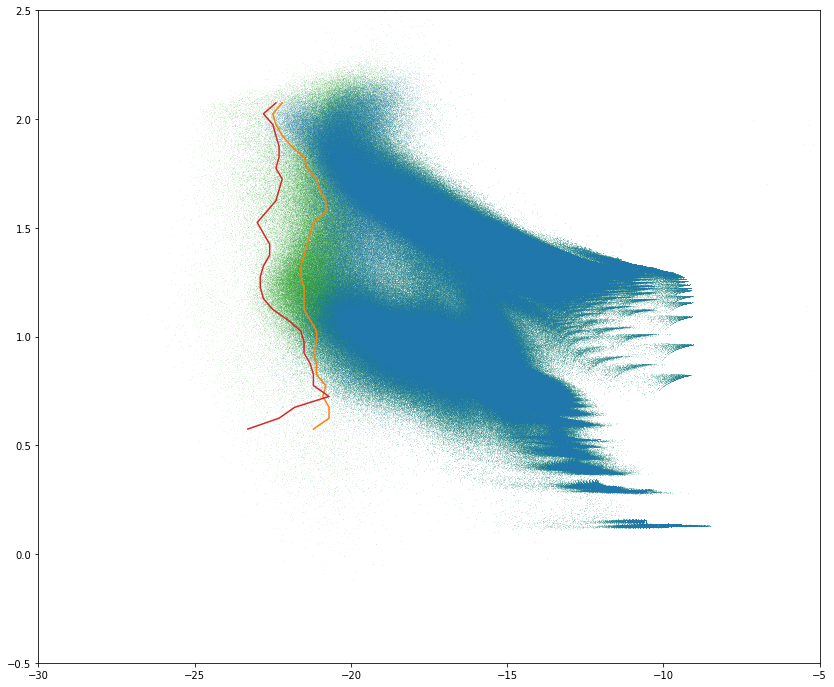

In [15]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

Computing...
0.12999999999999998
0.060000000000000005
0.02
0.02
0.02
0.060000000000000005
0.08
0.03
0.02
0.04
0.08
0.12999999999999998
0.21000000000000005
0.3100000000000001
0.48000000000000026
...done.
Computing...
0.12999999999999998
0.060000000000000005
0.02
0.02
0.02
0.05
0.07
0.03
0.02
0.04
0.09999999999999999
0.16
0.24000000000000007
0.36000000000000015
0.5200000000000002
...done.


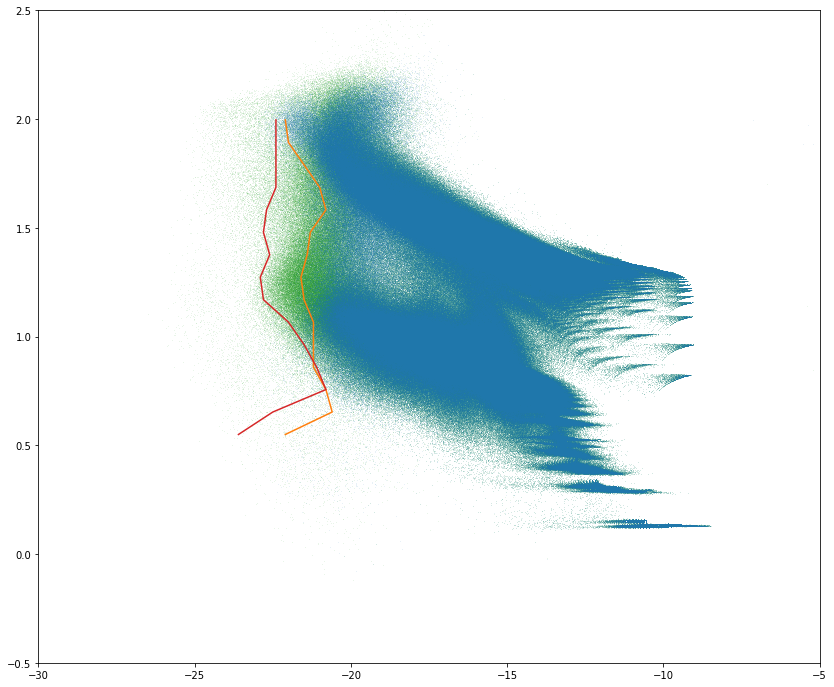

In [56]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,",",alpha=0.1,zorder=1)
e1,e2 = EDGE_fixed_Npoints(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_Nbins=15,y_points_per_bin=100000,x_max=-19,threashold=0.1)
plt.plot(e1,e2,"-",markersize=7)
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,",",alpha=0.1,zorder=-1)
ee1,ee2 = EDGE_fixed_Npoints(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_Nbins=15,y_points_per_bin=100000,x_max=-19,threashold=0.1) 
plt.plot(ee1,ee2,"-",markersize=7)
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

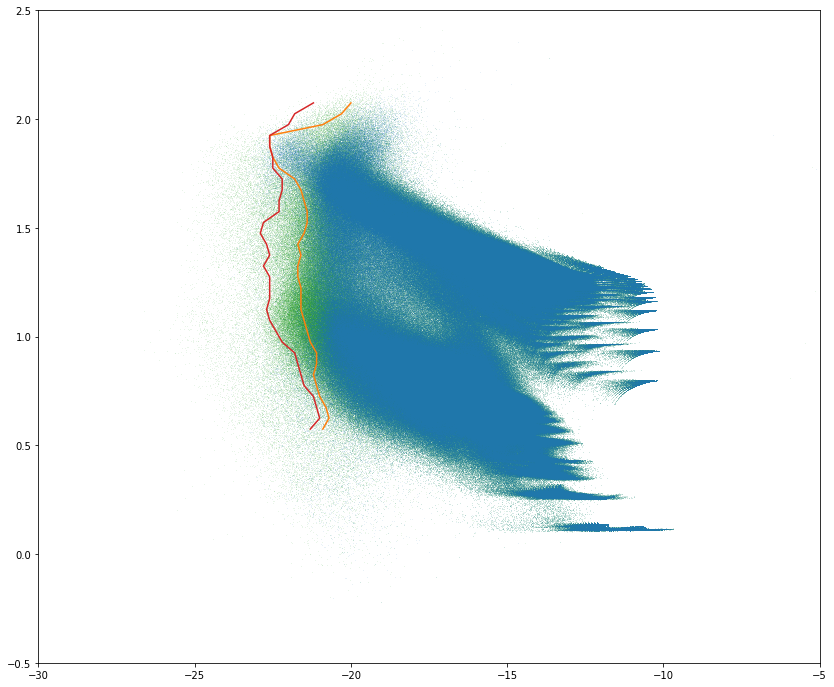

In [17]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

# Cut at 22.5

In [15]:
print('i_AB =22.5 means I_AB of:')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734),' @ z = 1.17')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.465),' @ z = 0.46')

i_AB =22.5 means I_AB of:
-21.256565734819656  @ z = 1.17
-18.79942677774084  @ z = 0.46


# My feedback

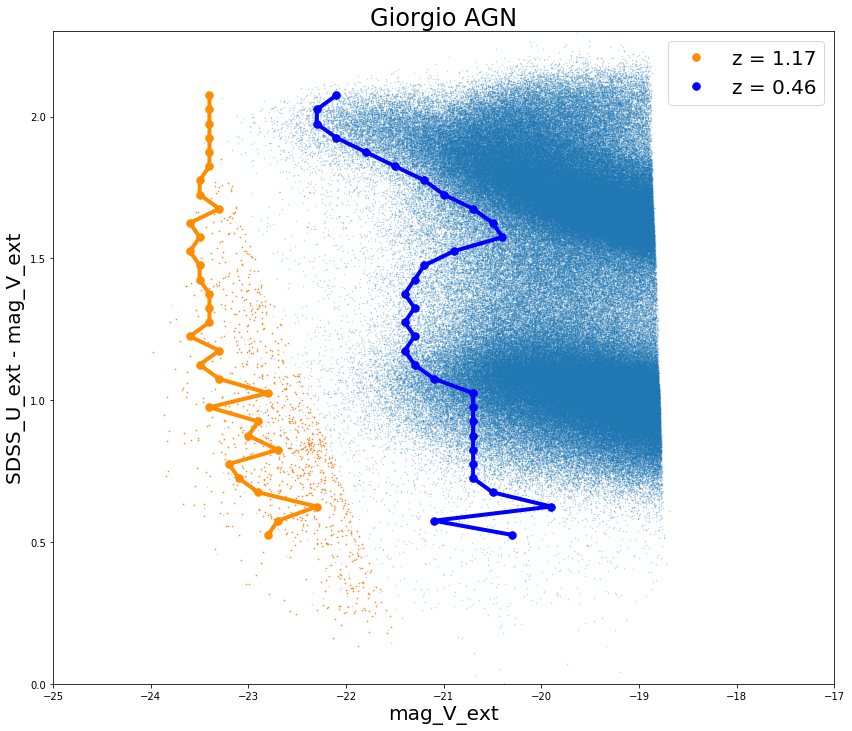

In [16]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)

# snapshot 37 (z=1.17)
sec37_gio= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
plt.plot(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
plt.plot(EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        lw=4,color='darkorange')
plt.plot(EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        ".",markersize=15,color='darkorange',label='z = 1.17')

# snapshot 47 (z=0.46)
sec47_gio = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.plot(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],".",alpha=1.3,zorder=-1,color='C0',markersize=1.)
plt.plot(EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        lw=4,color='blue')
plt.plot(EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        ".",markersize=15,color='blue',label='z = 0.46')

plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.title('Giorgio AGN')

plt.xlim(-25.,-17.)
plt.ylim(0.,2.3)


plt.legend()
plt.show()

In [18]:
# example histo in colour bin

def histo_in_colour_bin(min_col,max_col):
    plt.figure(figsize=(10,8))

    sec47_gio= np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))

    select_colour_bin = np.where(((u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio])<max_col)&((u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio])>min_col))
    plt.hist(v47_tot_feed[sec47_gio][select_colour_bin],bins=int((23-18)/0.1),range=(-23,-18),label=str(min_col)+'<U-V<'+str(max_col))
    #print(int((22-10)/0.1))

    #print(v47_tot_feed[sec47_gio].max())
    
    counts,b = np.histogram(v47_tot_feed[sec47_gio][select_colour_bin],bins=int((22-10)/0.1),range=(-22,-10))

    plt.axvline(b[np.where(counts==np.max(counts))],c='k',lw=3)


    #loop to find the edge
    for j in range(np.argmax(counts),0,-1):
        if (counts[j]<np.max(counts) * 0.15):
            edge_index = j
            break
    plt.axvline(b[j],c='k',lw=3)
    plt.xlabel("mag_V_ext")
    plt.ylabel('counts')
    plt.legend()
    plt.show()

In [17]:
# example histo in colour bin

def histo_in_colour_bin_general(min_col,max_col,u,v,i,redshift,thr=0.15,xbsz=0.1,save=True,path='./plots/image.png'):
    plt.figure(figsize=(10,8))
    
    sec = np.where(i<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=redshift))
    
    select_colour_bin = np.where(((u[sec]-v[sec])<max_col)&((u[sec]-v[sec])>min_col))
    plt.hist(v[sec][select_colour_bin],bins=int((26-18)/xbsz),range=(-26,-18),label=str(min_col)+'<U-V<'+str(max_col))
    #print(int((22-10)/0.1))

    counts,b = np.histogram(v[sec][select_colour_bin],bins=int((26-18)/xbsz),range=(-26,-18))

    #plt.axvline(b[np.where(counts==np.max(counts))],c='k',lw=3)
    plt.axvline(b[np.argmax(counts)],c='k',lw=3)

    #loop to find the edge
    for j in range(np.argmax(counts),0,-1):
        if (counts[j]<np.max(counts) * thr):
            edge_index = j
            break
    plt.axvline(b[j],c='k',lw=3)
    plt.xlabel("mag_V_ext")
    plt.ylabel('counts')
    plt.legend()
    if save:
        plt.savefig(path)
    
    plt.show()

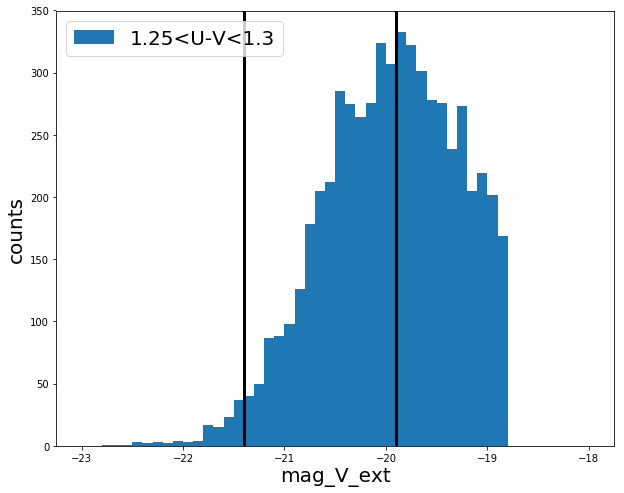

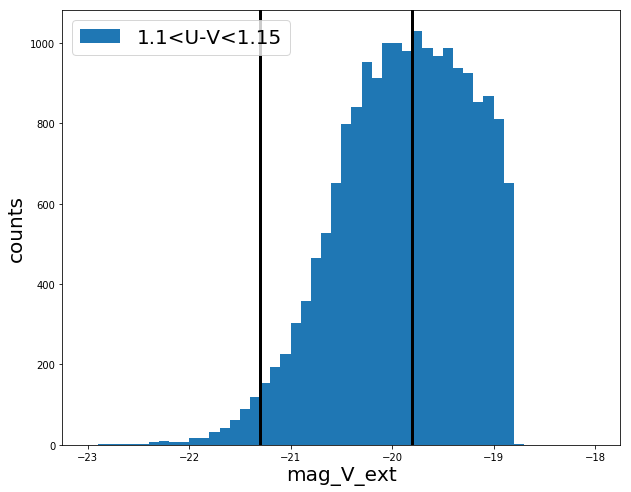

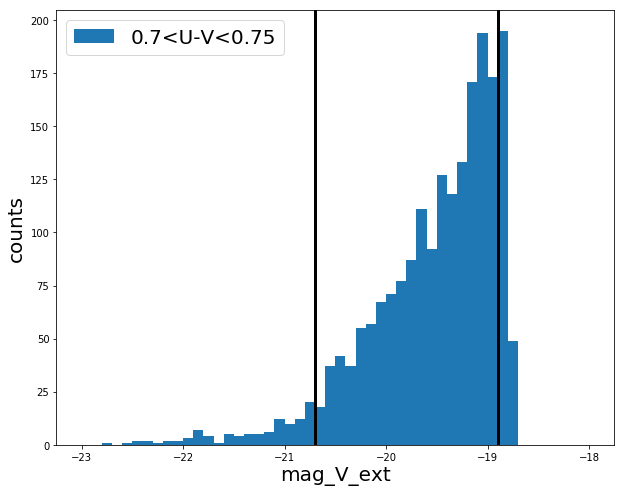

In [20]:
histo_in_colour_bin(min_col=1.25,max_col=1.30)
histo_in_colour_bin(min_col=1.10,max_col=1.15)
histo_in_colour_bin(min_col=0.70,max_col=0.75)

In [19]:
def colmag_cut(v37=v37_tot_feed,
               u37=u37_tot_feed,
               i37=i37_tot_feed,
               v47=v47_tot_feed,
               u47=u47_tot_feed,
               i47=i47_tot_feed,
               title='Giorgio AGN',
               path_fig='./plots/colmag_giorgio_feed.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.05,
               thr=0.15):

    plt.figure(figsize=(14,12))
    plt.ylim(-0.5,2.5)
    plt.xlim(-30,-5)

    # snapshot 37 (z=1.17)
    sec37= np.where(i37<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

    plt.plot(v37[sec37],u37[sec37]-v37[sec37],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)

    plt.plot(EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            lw=4,color='darkorange')
    plt.plot(EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            ".",markersize=15,color='darkorange',label='z = 1.17')

    # snapshot 47 (z=0.46)
    sec47 = np.where(i47<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
    plt.plot(v47[sec47],u47[sec47]-v47[sec47],".",alpha=0.3,zorder=-1,color='C0',markersize=1.)
    plt.plot(EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            lw=4,color='blue')
    plt.plot(EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            ".",markersize=15,color='blue',label='z = 0.46')

    plt.xlabel("mag_V_ext")
    plt.ylabel("SDSS_U_ext - mag_V_ext")
    plt.title(title)

    plt.xlim(-26.,-17.)
    plt.ylim(0.,2.3)

    plt.legend()
    if save_fig:
        plt.savefig(path_fig)
    plt.show()

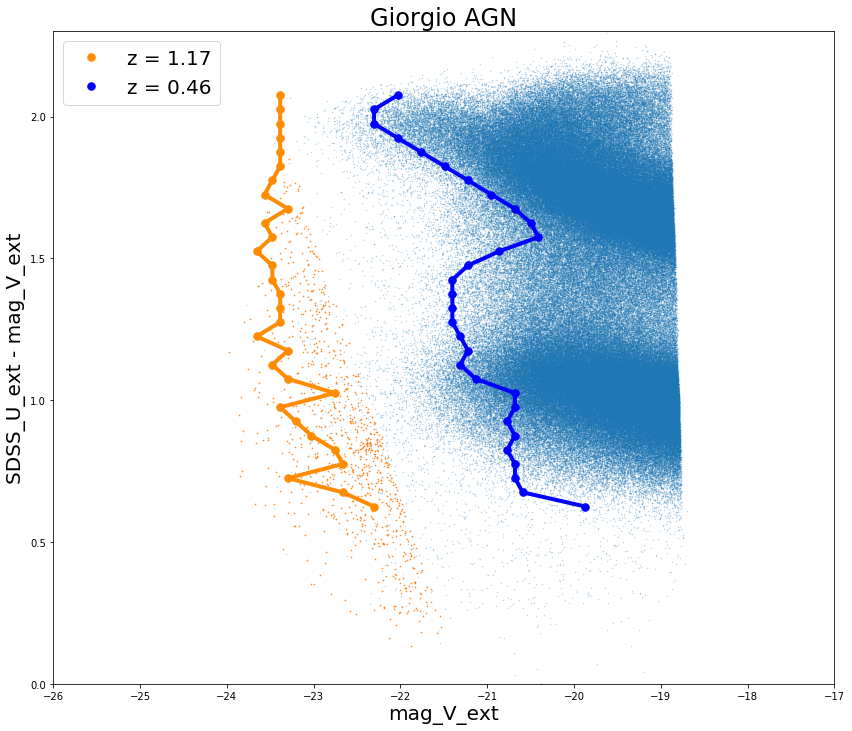

In [21]:
colmag_cut(v37=v37_tot_feed,
           u37=u37_tot_feed,
           i37=i37_tot_feed,
           v47=v47_tot_feed,
           u47=u47_tot_feed,
           i47=i47_tot_feed,
           title='Giorgio AGN',
           path_fig='./plots/colmag_giorgio_feed.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.05,
           thr=0.15)

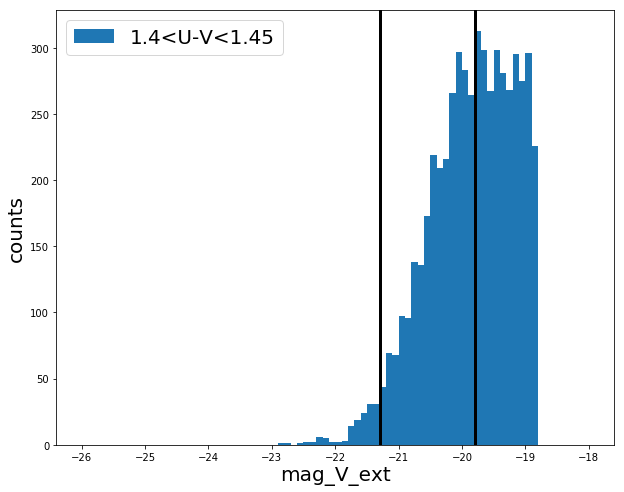

In [22]:
histo_in_colour_bin_general(min_col=1.40,
                            max_col=1.45,
                            v=np.array(v47_tot_feed),
                            u=np.array(u47_tot_feed),
                            i=np.array(i47_tot_feed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

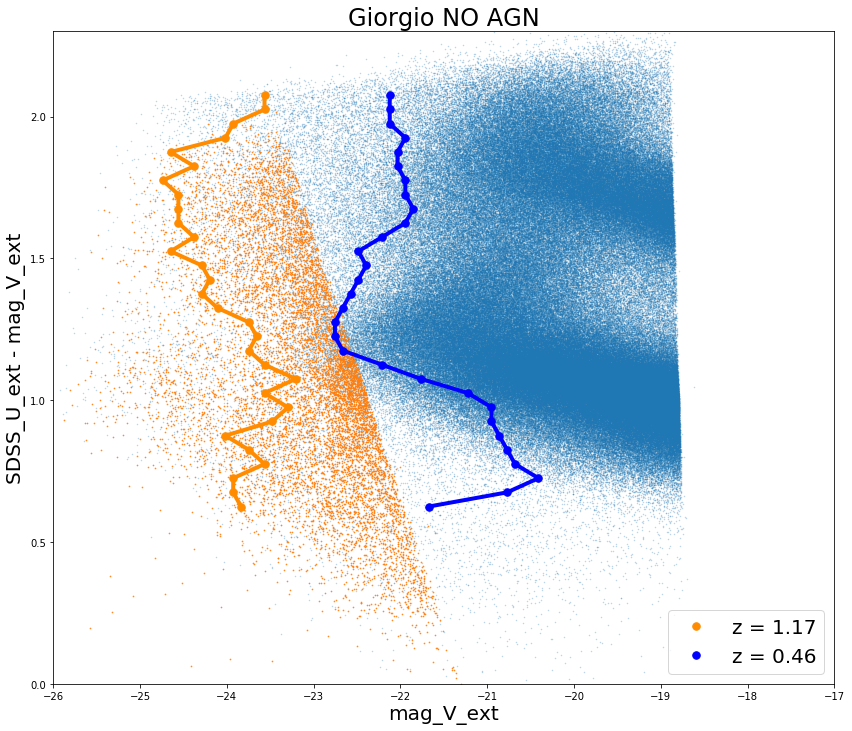

In [23]:
colmag_cut(v37=v37_tot_nofeed,
           u37=u37_tot_nofeed,
           i37=i37_tot_nofeed,
           v47=v47_tot_nofeed,
           u47=u47_tot_nofeed,
           i47=i47_tot_nofeed,
           title='Giorgio NO AGN',
           path_fig='./plots/colmag_giorgio_nofeed.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.05,
           thr=0.15)

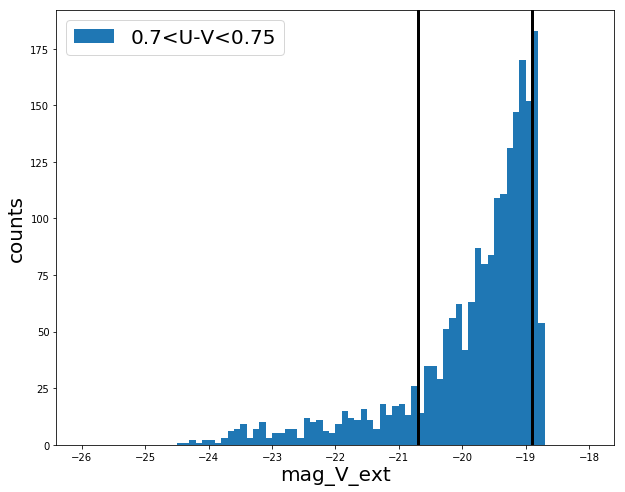

In [166]:
histo_in_colour_bin_general(min_col=0.7,
                            max_col=0.75,
                            v=np.array(v47_tot_nofeed),
                            u=np.array(u47_tot_nofeed),
                            i=np.array(i47_tot_nofeed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

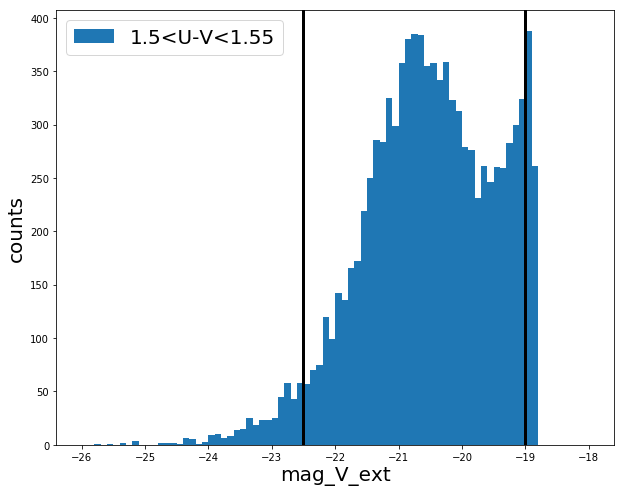

In [167]:
histo_in_colour_bin_general(min_col=1.50,
                            max_col=1.55,
                            v=np.array(v47_tot_nofeed),
                            u=np.array(u47_tot_nofeed),
                            i=np.array(i47_tot_nofeed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

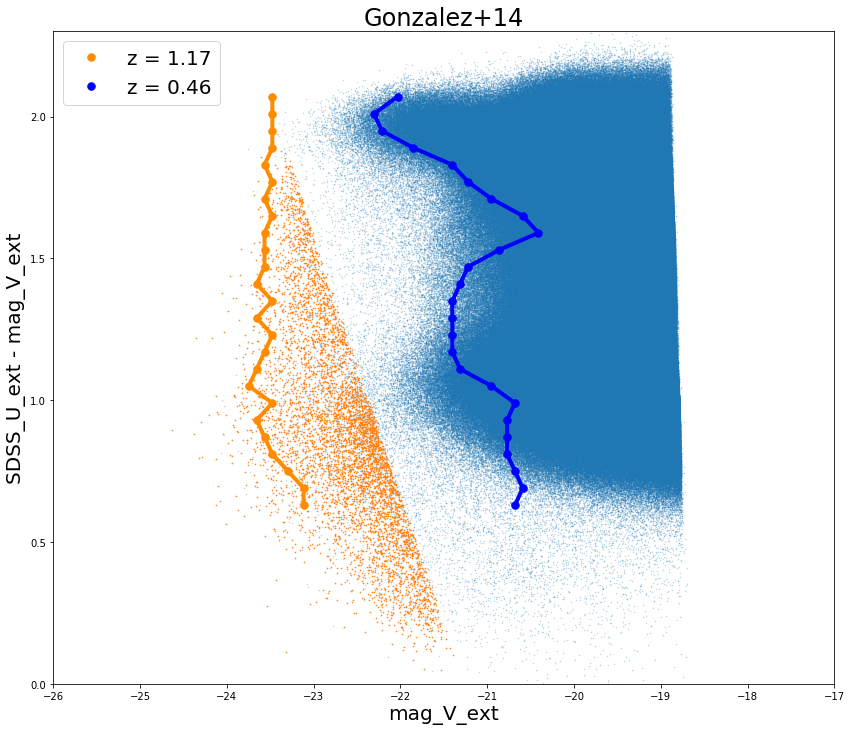

In [24]:
colmag_cut(v37=np.array(ALL37['mag_V_ext']),
           u37=np.array(ALL37['SDSS_u_ext']),
           i37=np.array(ALL37['SDSS_i_obs_ext']),
           v47=np.array(ALL47['mag_V_ext']),
           u47=np.array(ALL47['SDSS_u_ext']),
           i47=np.array(ALL47['SDSS_i_obs_ext']),
           title='Gonzalez+14',
           path_fig='./plots/colmag_violetta.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.06,
           thr=0.15)

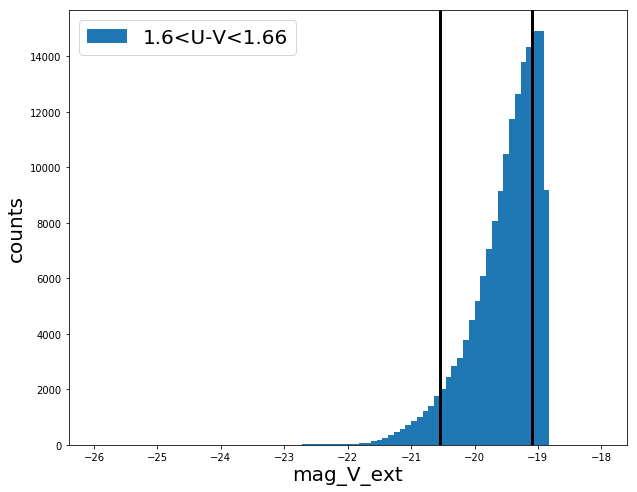

In [32]:
histo_in_colour_bin_general(min_col=1.60,
                            max_col=1.66,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15,
                            path='./plots/gonzalez_histo_160_166.png')

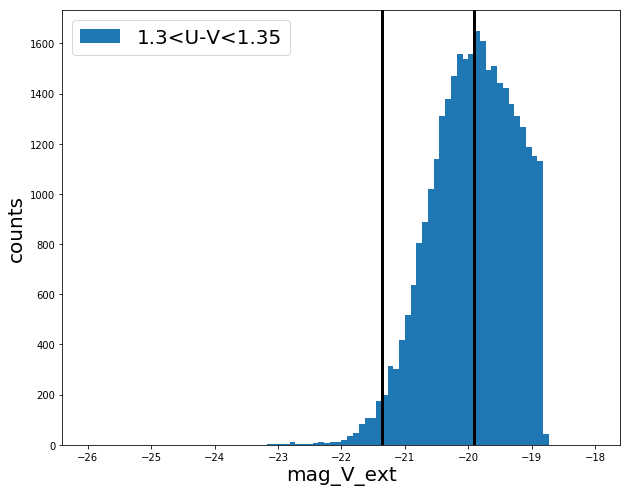

In [146]:
histo_in_colour_bin_general(min_col=1.30,
                            max_col=1.35,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15)

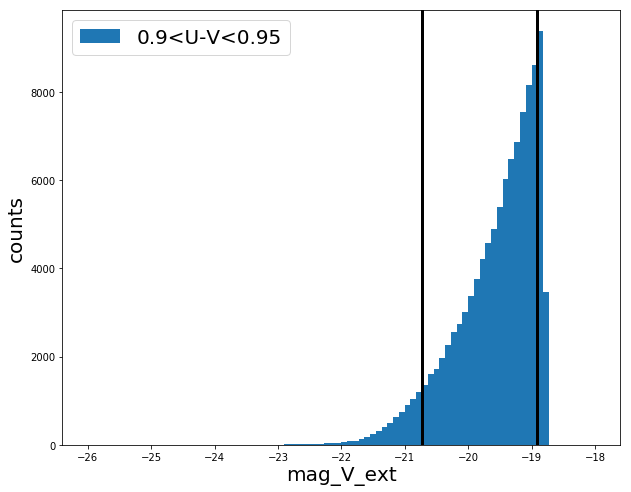

In [169]:
histo_in_colour_bin_general(min_col=0.9,
                            max_col=0.95,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15)

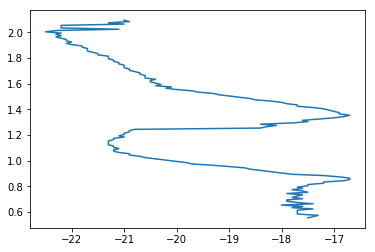

In [21]:
x,y = EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.01)

plt.plot(x,y)
plt.show()

# Luminosity function

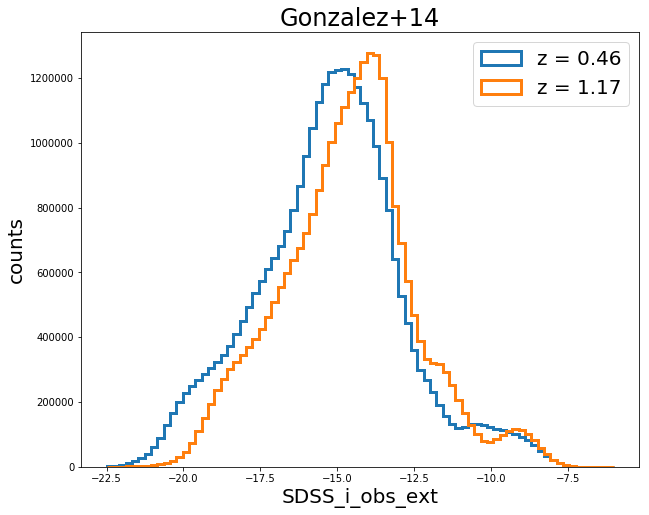

In [22]:
plt.figure(figsize=(10,8))
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Gonzalez+14')
plt.legend()
plt.savefig('./plots/Violetta_luminosity_function.png')
plt.show()

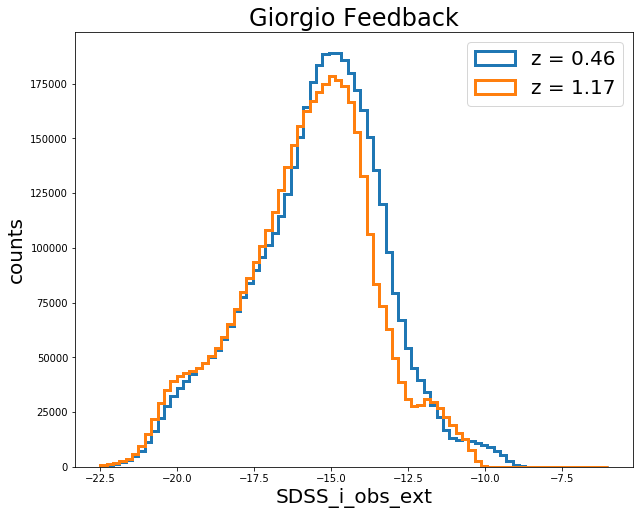

In [23]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/Giorgio_luminosity_function.png')
plt.show()

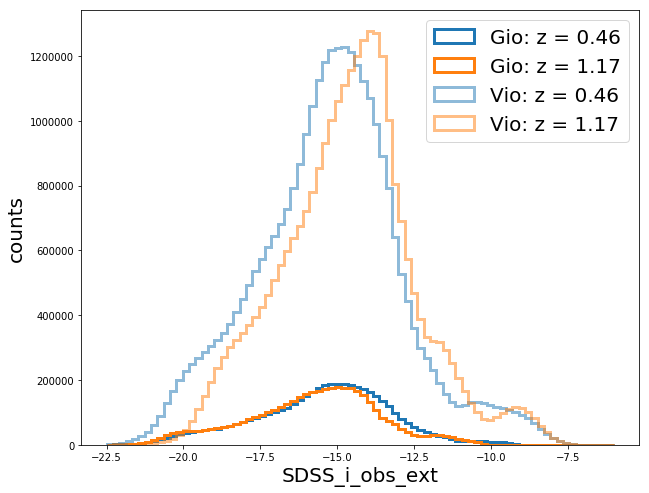

In [24]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Gio: z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Gio: z = 1.17')
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Vio: z = 0.46',alpha=0.5)
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Vio: z = 1.17',alpha=0.5)
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
#plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/i_band_luminosity_function.png')
plt.show()

# Violetta Colour-magnitude against mine

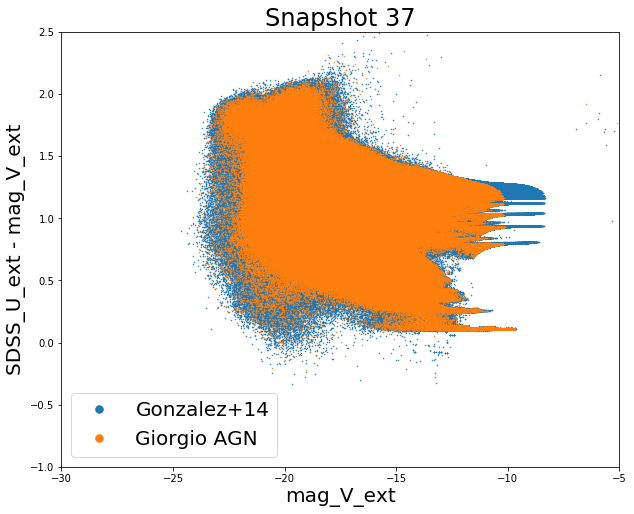

In [25]:
plt.figure(figsize=(10,8))
plt.plot(ALL37['mag_V_ext'],ALL37['SDSS_u_ext']-ALL37['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 37')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
plt.savefig('./plots/colmag37_comparison.png')
plt.show()

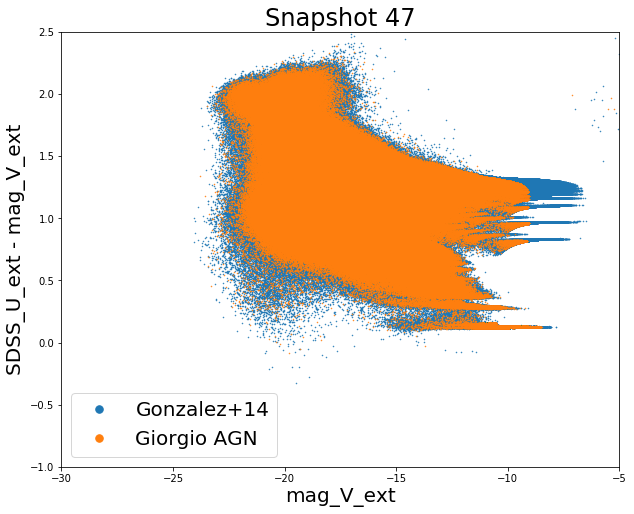

In [51]:
plt.figure(figsize=(10,8))
plt.plot(ALL47['mag_V_ext'],ALL47['SDSS_u_ext']-ALL47['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 47')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
#plt.savefig('./plots/colmag47_comparison.png')
plt.show()

# Try cut 22.5 on both

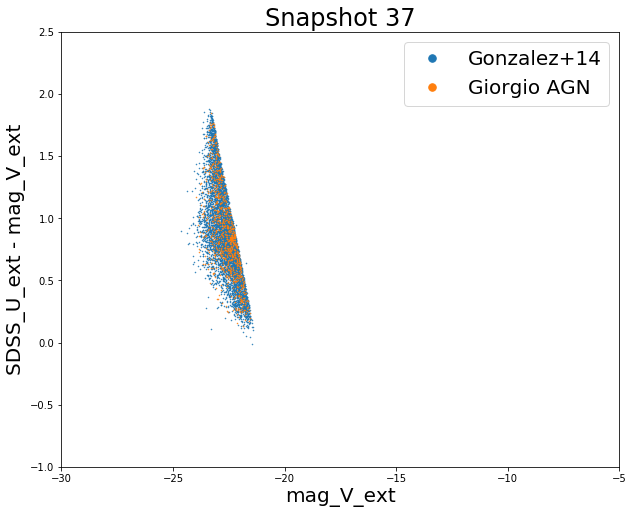

In [26]:
sec37_vio = np.where(ALL37['SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
sec37_gio= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

plt.figure(figsize=(10,8))
plt.plot(np.array(ALL37['mag_V_ext'])[sec37_vio],np.array(ALL37['SDSS_u_ext'])[sec37_vio]-np.array(ALL37['mag_V_ext'])[sec37_vio],".",markersize=1,label='Gonzalez+14')
plt.plot(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],".",markersize=1, label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 37')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
#plt.savefig('./plots/colmag37_comparison_cut225.png')
plt.show()

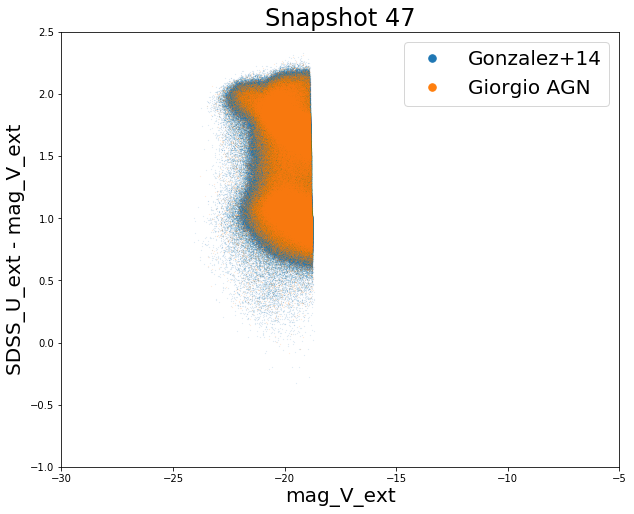

In [27]:
sec47_vio = np.where(ALL47['SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
sec47_gio= np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))

plt.figure(figsize=(10,8))
plt.plot(np.array(ALL47['mag_V_ext'])[sec47_vio],np.array(ALL47['SDSS_u_ext'])[sec47_vio]-np.array(ALL47['mag_V_ext'])[sec47_vio],".",markersize=0.1,label='Gonzalez+14')
plt.plot(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],".",markersize=0.1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 47')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=150)
#plt.savefig('./plots/colmag47_comparison_cut225.png')
plt.show()

In [1]:
2+2

4